<a href="https://colab.research.google.com/github/bs3537/DS-Unit-2-Kaggle-Challenge/blob/master/Bhav_assignment_Confusion_Matrix_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
#Import libraries

import numpy as np
from numpy import mean, std
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [0]:
#split into train and val data
from sklearn.model_selection import train_test_split

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val
#***For confusion matrix plot, size of validation data should be equal to test data, so use test_size=len(test)
train, val = train_test_split(train, test_size=len(test), 
                              stratify=train['status_group'], random_state=50)

In [0]:
#wrangle function

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
  
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 150].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features


In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
# pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features='auto', random_state=50)
)

In [10]:
# Fit pipeline on train
%time
pipeline.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'lga',
                                      'public_meeting', 'scheme_management',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_type',
                                      'source_class', 'waterpoint_type',
                                      'waterp...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_lea

In [0]:
# find predictions on validation dataset
y_pred = pipeline.predict(X_val)

In [12]:
from sklearn.metrics import accuracy_score
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8042206435436691


In [0]:
#Create confusion matrix



In [13]:
!pip install scikit-plot

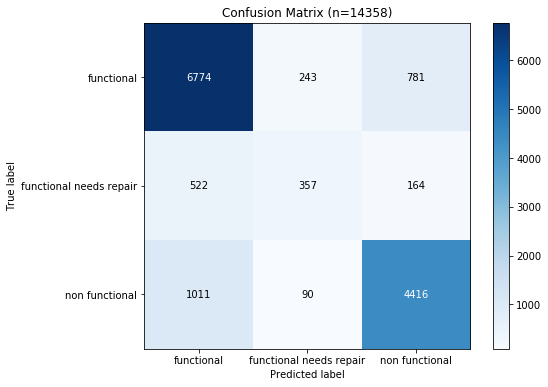

In [14]:
#Plot absolute predicted number (use Normalize=False)
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_val, y_pred, 
                                    figsize=(8,6),
                                    title=f'Confusion Matrix (n={len(y_val)})',
                                    normalize=False);

In [0]:
#Test accuracy: sum of diagonal values along left top to bottom right (TP+TN)/(Total test data)

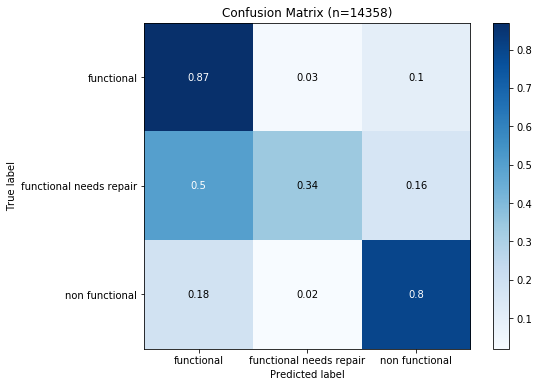

In [16]:
#Plotting confusion matrix as accuracy %ages, use normalize=True

skplt.metrics.plot_confusion_matrix(y_val, y_pred, 
                                    figsize=(8,6),
                                    title=f'Confusion Matrix (n={len(y_val)})',
                                    normalize=True);

In [17]:
#Precision and recall
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.87      0.84      7798
functional needs repair       0.52      0.34      0.41      1043
         non functional       0.82      0.80      0.81      5517

               accuracy                           0.80     14358
              macro avg       0.72      0.67      0.69     14358
           weighted avg       0.80      0.80      0.80     14358



In [0]:
#Plotting ROC curve

In [0]:
from sklearn.metrics import roc_curve, auc

In [0]:
#ROC curve, we need 2 classes in target, rather than 3
#combine functional, need repair and non funtional into one category, need repair
#ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


In [21]:
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

In [22]:
# convert train data into functional and need repair
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

In [0]:
#refit model using refined binary target
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

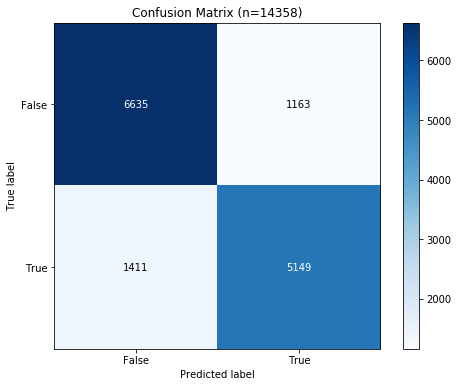

In [24]:
#plot refined confusion matrix

skplt.metrics.plot_confusion_matrix(y_val, y_pred, 
                                    figsize=(8,6),
                                    title=f'Confusion Matrix (n={len(y_val)})',
                                    normalize=False);

In [0]:
# Predicted probabilities for positive class
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

In [0]:
#GET ROC DATA
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc_auc = auc(fpr, tpr)

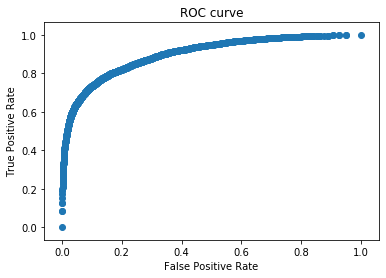

In [27]:
 
# plot the "Receiver Operating Characteristic" curve
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [28]:
# Use scikit-learn to calculate the area under the curve.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.8995377273878856